# Analysis of Preprocessed CDMS Prediction Dataset

This notebook loads and analyzes the `processed_prediction_dataset.npz` file created by `data/Hacettepe/dataset_builder.py`.

The dataset is structured for a prediction task:
- **X (`eeg_windows`)**: The first 4 seconds of filtered EEG data (14 channels, 1024 samples).
- **Y (`cs_labels`)**: The binary label (0=Comfortable, 1=Sickness) for the original 8-second trial.
- **Groups (`participant_ids`)**: Identifier for the participant corresponding to each trial.
- **Sub-Groups (`session_ids`)**: Identifier for the specific session (Participant/Session) for each trial.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter

# --- Configuration --- 
NPZ_FILE_PATH = "/Users/merterdem/iui_lab/CDMS_Forecast/data/npz/processed_prediction_dataset.npz" # Adjust path if needed

## 1. Load Data from .npz File

In [3]:
try:
    data = np.load(NPZ_FILE_PATH, allow_pickle=True)
    print(f"Successfully loaded: {NPZ_FILE_PATH}")
    print(f"Arrays found: {list(data.keys())}")
except FileNotFoundError:
    print(f"ERROR: File not found at {NPZ_FILE_PATH}. Please check the path.")
    data = None
except Exception as e:
    print(f"ERROR: Could not load file: {e}")
    data = None

Successfully loaded: /Users/merterdem/iui_lab/CDMS_Forecast/data/npz/processed_prediction_dataset.npz
Arrays found: ['eeg_windows', 'cs_labels', 'participant_ids', 'session_ids']


## 2. Inspect Array Shapes and Data Types

In [4]:
if data:
    eeg_windows = data['eeg_windows']
    cs_labels = data['cs_labels']
    participant_ids = data['participant_ids']
    session_ids = data['session_ids']

    print("--- Array Details ---")
    print(f"'eeg_windows' (X):\tShape={eeg_windows.shape}, \tDataType={eeg_windows.dtype}")
    print(f"'cs_labels' (Y):\tShape={cs_labels.shape}, \tDataType={cs_labels.dtype}")
    print(f"'participant_ids':\tShape={participant_ids.shape}, \tDataType={participant_ids.dtype}")
    print(f"'session_ids':\tShape={session_ids.shape}, \tDataType={session_ids.dtype}")

    # Verify expected shapes
    N_samples = eeg_windows.shape[0]
    N_channels = eeg_windows.shape[1]
    N_timesteps = eeg_windows.shape[2]
    print(f"\nDetected: {N_samples} samples, {N_channels} channels, {N_timesteps} timesteps per sample.")
    assert N_channels == 14, f"Expected 14 channels, found {N_channels}"
    assert N_timesteps == 1024, f"Expected 1024 timesteps (4s), found {N_timesteps}"
    assert cs_labels.shape == (N_samples,), f"Label shape mismatch: expected ({N_samples},), found {cs_labels.shape}"
    assert participant_ids.shape == (N_samples,), f"Participant ID shape mismatch"
    assert session_ids.shape == (N_samples,), f"Session ID shape mismatch"

--- Array Details ---
'eeg_windows' (X):	Shape=(1950, 14, 1024), 	DataType=float64
'cs_labels' (Y):	Shape=(1950,), 	DataType=int32
'participant_ids':	Shape=(1950,), 	DataType=object
'session_ids':	Shape=(1950,), 	DataType=object

Detected: 1950 samples, 14 channels, 1024 timesteps per sample.


## 3. Analyze Overall Label Distribution

--- Overall Label Distribution ---
Total Samples: 1950
Class 0 (Comfortable): 1182 samples (60.62%)
Class 1 (Sickness):    768 samples (39.38%)


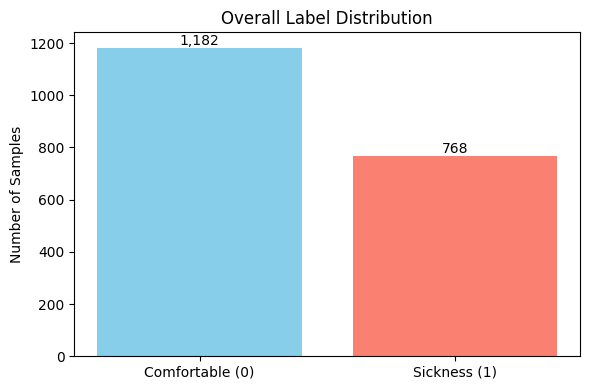

In [5]:
if data:
    label_counts = Counter(cs_labels)
    total_samples = len(cs_labels)
    
    print("--- Overall Label Distribution ---")
    print(f"Total Samples: {total_samples}")
    
    count0 = label_counts.get(0, 0)
    count1 = label_counts.get(1, 0)
    pct0 = (count0 / total_samples) * 100 if total_samples > 0 else 0
    pct1 = (count1 / total_samples) * 100 if total_samples > 0 else 0
    
    print(f"Class 0 (Comfortable): {count0} samples ({pct0:.2f}%)")
    print(f"Class 1 (Sickness):    {count1} samples ({pct1:.2f}%)")
    
    # Optional: Plotting the distribution
    plt.figure(figsize=(6, 4))
    bars = plt.bar(['Comfortable (0)', 'Sickness (1)'], [count0, count1], color=['skyblue', 'salmon'])
    plt.title('Overall Label Distribution')
    plt.ylabel('Number of Samples')
    plt.bar_label(bars, fmt='{:,.0f}')
    plt.tight_layout()
    plt.show()

## 4. Analyze Distribution per Participant

--- Samples per Participant ---
Total Participants: 33


,sample_count
participant_id,
P1,70
P10,56
P11,59
P12,56
P13,60
P14,67
P15,67
P16,49
P17,56


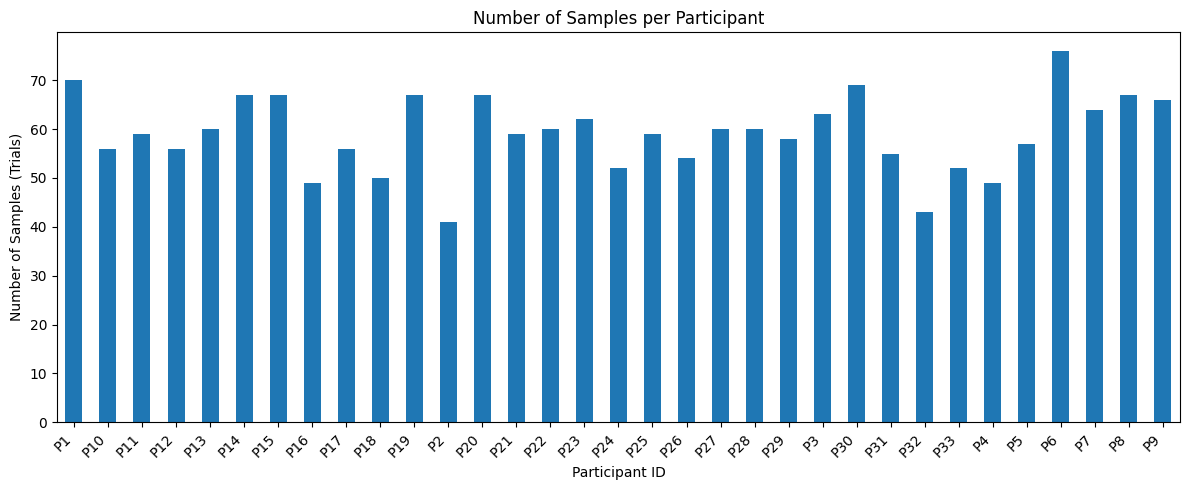

In [6]:
if data:
    pid_counts = Counter(participant_ids)
    unique_pids = sorted(pid_counts.keys())
    
    print(f"--- Samples per Participant ---")
    print(f"Total Participants: {len(unique_pids)}")
    
    # Create a DataFrame for better display
    pid_df = pd.DataFrame.from_dict(pid_counts, orient='index', columns=['sample_count'])
    pid_df.index.name = 'participant_id'
    pid_df = pid_df.sort_index()
    
    display(pid_df)
    
    # Optional: Plotting the distribution
    plt.figure(figsize=(12, 5))
    pid_df['sample_count'].plot(kind='bar')
    plt.title('Number of Samples per Participant')
    plt.xlabel('Participant ID')
    plt.ylabel('Number of Samples (Trials)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 5. (Optional) Plot a Sample EEG Window

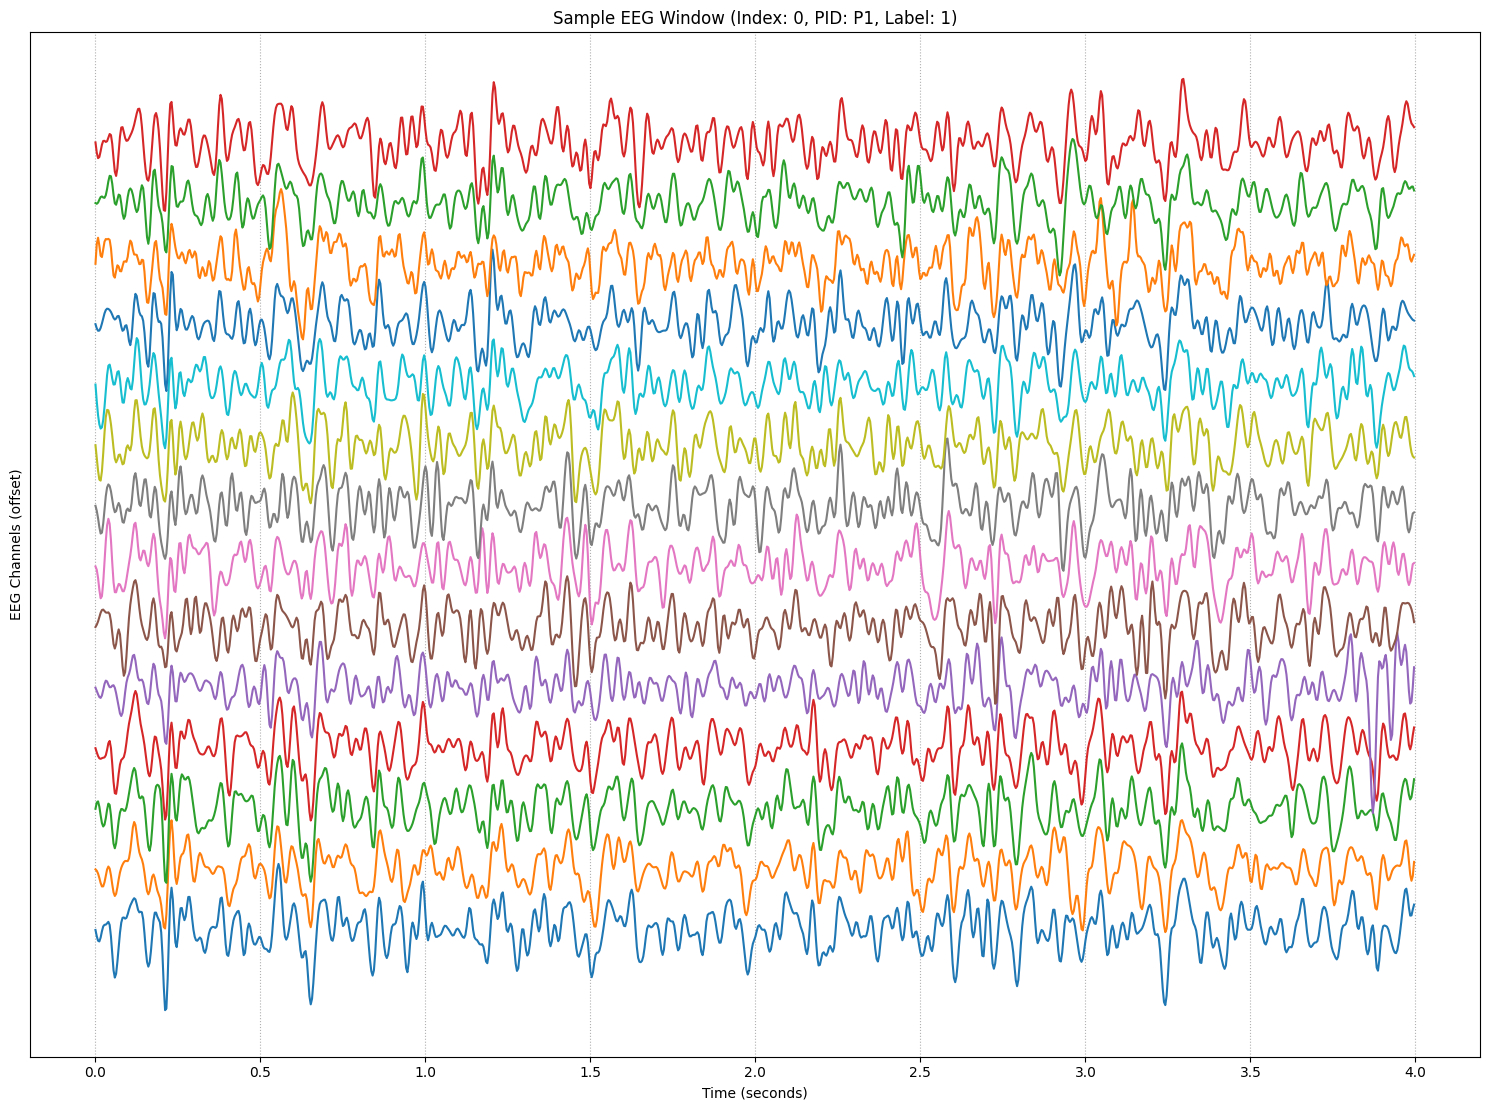

In [7]:
# Set sample_index to view a specific sample
sample_index = 0 

if data and sample_index < len(eeg_windows):
    sample_eeg = eeg_windows[sample_index]  # Shape (14, 1024)
    sample_label = cs_labels[sample_index]
    sample_pid = participant_ids[sample_index]

    # Create a time axis (assuming 256 Hz)
    sample_rate = 256
    time_sec = np.arange(sample_eeg.shape[1]) / sample_rate

    n_channels_to_plot = sample_eeg.shape[0]
    plt.figure(figsize=(15, n_channels_to_plot * 0.8))

    # Plot each channel separately with an offset for visibility
    offset_scale = np.std(sample_eeg) * 3 # Adjust scale as needed
    for i in range(n_channels_to_plot):
        plt.plot(time_sec, sample_eeg[i] + i * offset_scale, label=f'Ch {i+1}')

    plt.yticks([]) # Hide y-axis ticks as absolute values are less important here
    plt.xlabel('Time (seconds)')
    plt.ylabel('EEG Channels (offset)')
    plt.title(f'Sample EEG Window (Index: {sample_index}, PID: {sample_pid}, Label: {int(sample_label)})')
    plt.grid(True, axis='x', linestyle=':')
    plt.tight_layout()
    plt.show()
else:
    print("Data not loaded or sample_index out of bounds.")